In [1]:
import numpy as np
%matplotlib inline
import os

%load_ext autoreload
%autoreload 2

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'x-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 8),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize}
pylab.rcParams.update(params)

from astropy.io import fits
from astropy import units as u
from IPython.display import Image
import fsps
import sedpy
import prospect
import specutils
from specutils import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum

In [2]:
hdul = fits.open('../data/keck_data/bluedot/bluedot_coadd.fits')

In [3]:
info = hdul.info()
hdr = hdul[0].header
data = hdul[1].data

Filename: ../data/keck_data/bluedot/bluedot_coadd.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (2223,)   uint8   
  1  /Users/yifei/Dropbox/Keck_Data/data4kate_reduced/bluedot/keck_dei...    1 BinTableHDU     20   8109R x 4C   [D, D, D, K]   


In [4]:
w = data['wave']
f = data['flux']

Text(0, 0.5, 'flux')

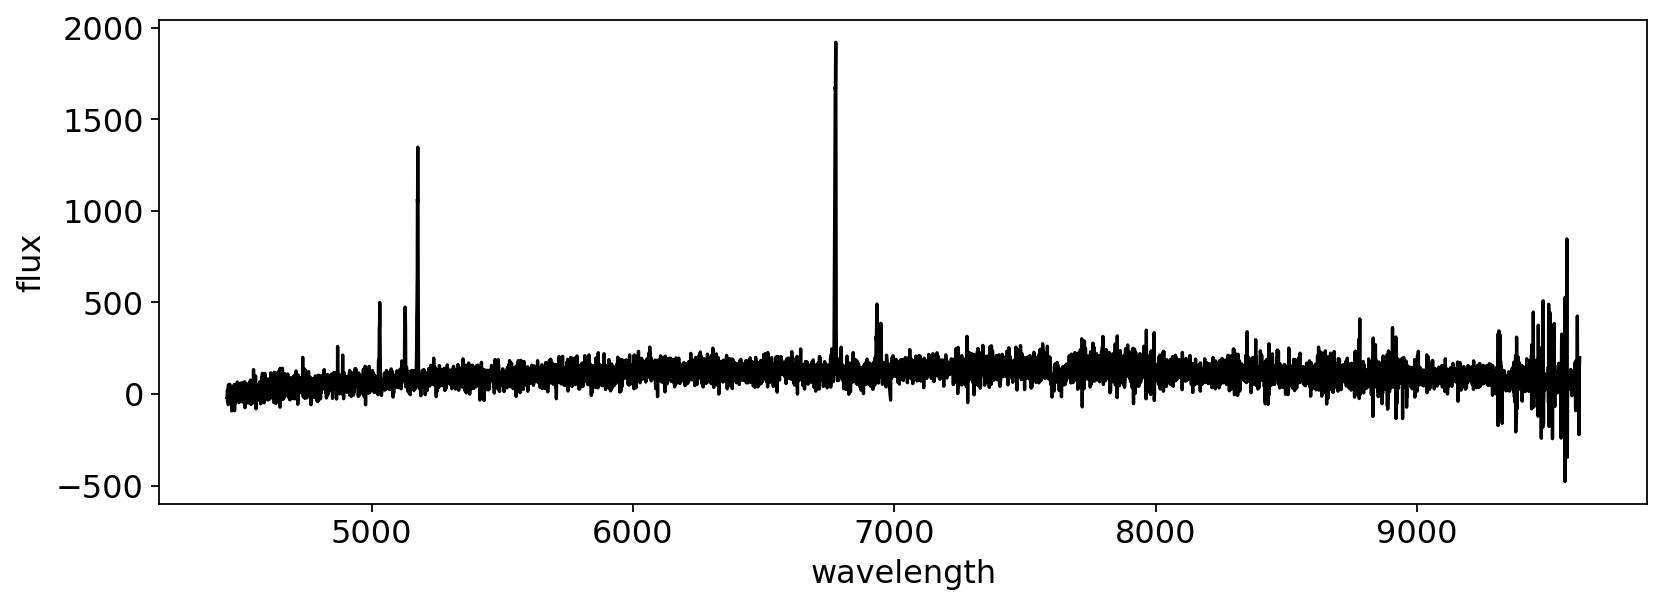

In [5]:
plt.figure(figsize=(12,4))
plt.plot(w, f, color='k')
plt.xlabel('wavelength')
plt.ylabel('flux')

(4800, 5300)

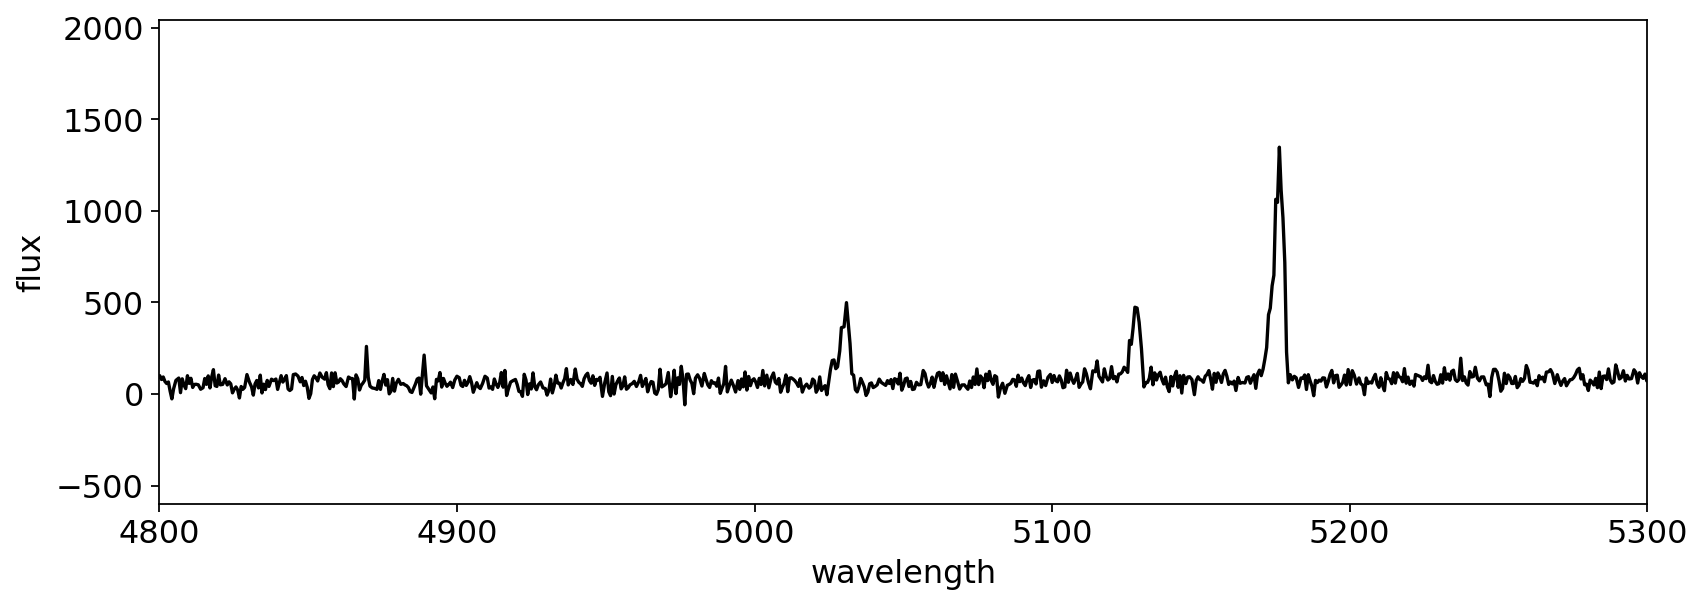

In [6]:
plt.figure(figsize=(12,4))
plt.plot(w, f, color='k')
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.xlim(4800, 5300)

In [7]:
#>>> lamb = 10**specdata['loglam'] * u.AA 
#>>> flux = specdata['flux'] * 10**-17 * u.Unit('erg cm-2 s-1 AA-1') 
wave = w*u.AA
flux = f*10**-17 * u.Unit('erg cm-2 s-1 AA-1') #??
spec = Spectrum1D(spectral_axis=wave, flux=flux) 

Normalize continuum:

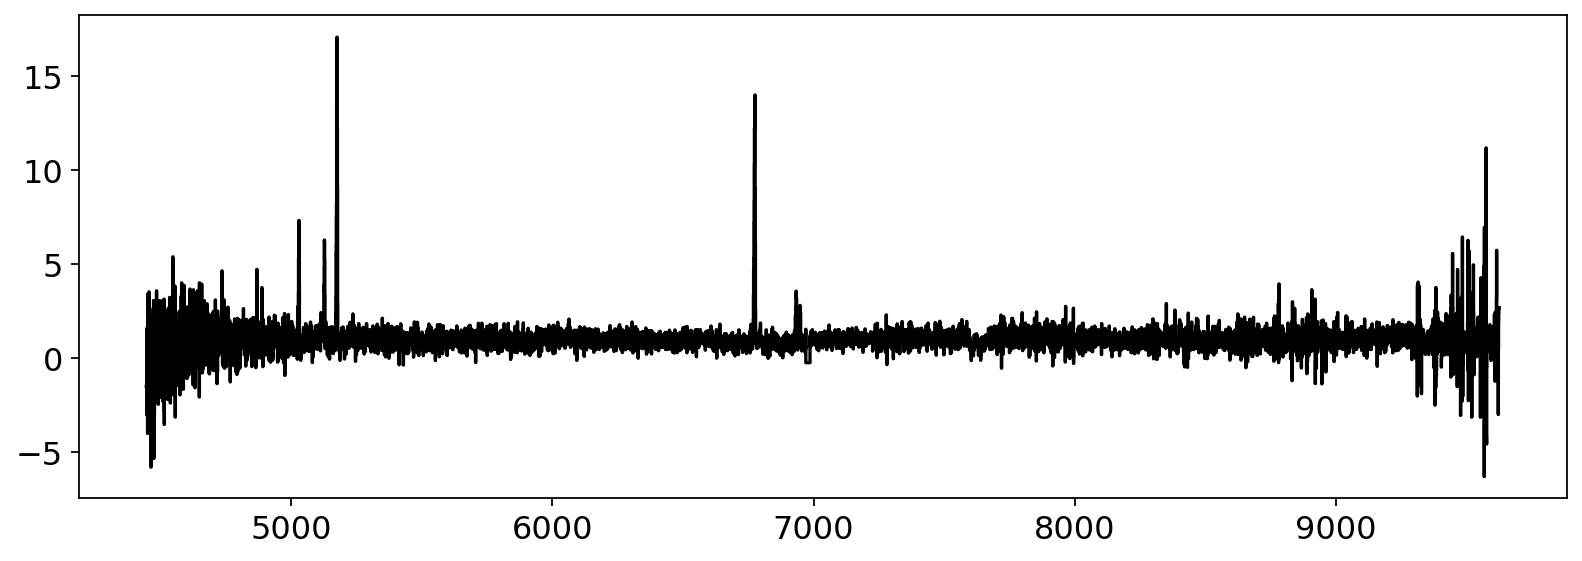

In [8]:
cont_norm_spec = spec / fit_generic_continuum(spec)(spec.spectral_axis) 
plt.figure(figsize=(12,4))
#f, ax = plt.subplots()  
plt.step(cont_norm_spec.wavelength, cont_norm_spec.flux, color='black')  
#ax.set_xlim(654*u.nm, 660*u.nm)  

In [9]:
from specutils.manipulation import noise_region_uncertainty
noise_region = SpectralRegion(6000*u.AA, 6003*u.AA)
spectrum = noise_region_uncertainty(cont_norm_spec, noise_region)

from specutils.fitting import find_lines_threshold
lines = find_lines_threshold(spectrum, noise_factor=10)

lines[lines['line_type'] == 'emission']  


If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]

If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning.


line_center,line_type,line_center_index
Angstrom,,
float64,str10,int64
4451.822406137359,emission,9
4452.907682522851,emission,11
4456.70845008706,emission,17
4473.037590272296,emission,43
4474.533282796795,emission,45
4478.955596139232,emission,52
4483.412542407742,emission,59
4485.599960304062,emission,63


(4800, 5200)

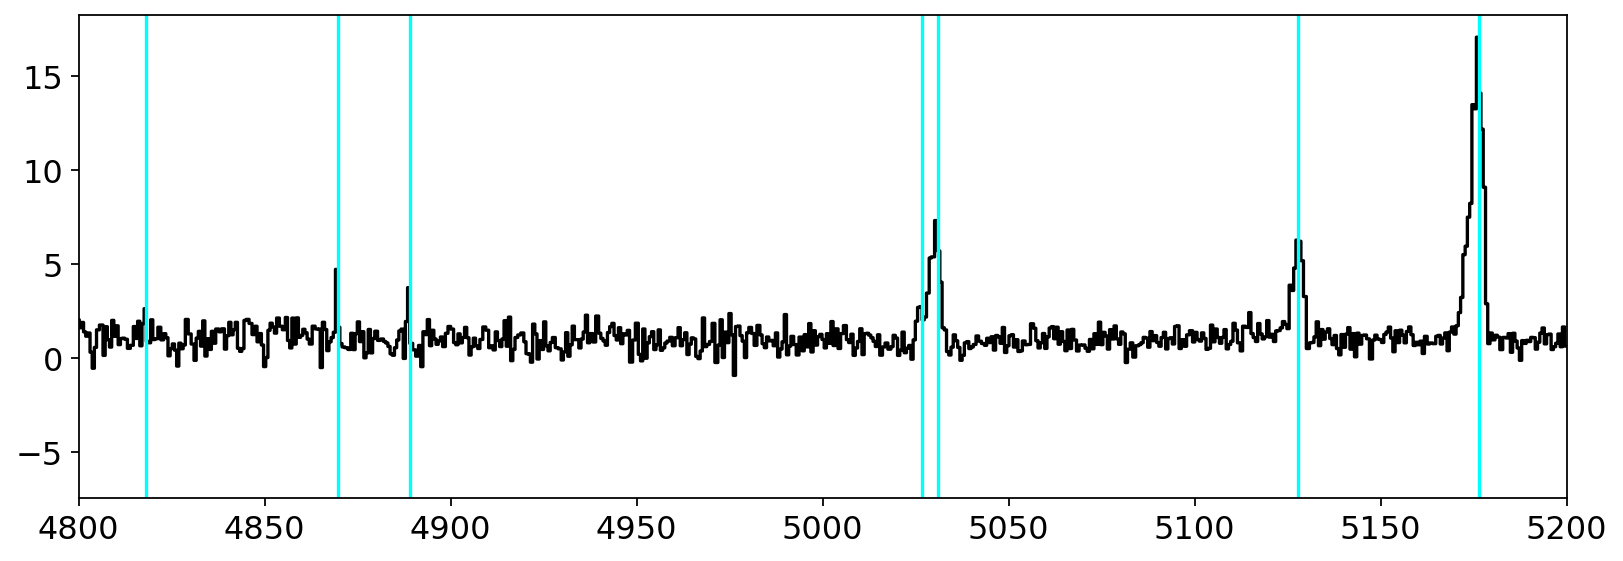

In [10]:
cont_norm_spec = spec / fit_generic_continuum(spec)(spec.spectral_axis) 
plt.figure(figsize=(12,4))
plt.step(cont_norm_spec.wavelength, cont_norm_spec.flux, color='black')  
for line in lines:
    plt.axvline(line['line_center'].value, color='cyan')
plt.xlim(4800,5200)

(6600, 7100)

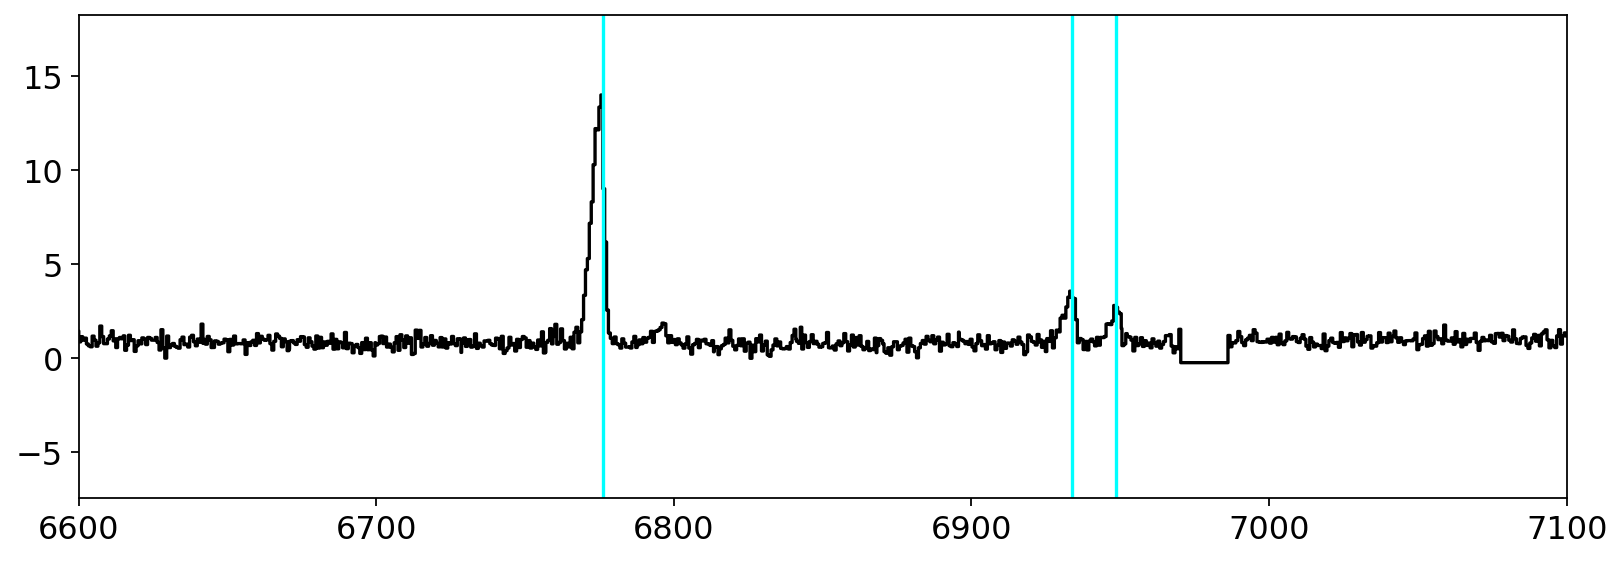

In [11]:
cont_norm_spec = spec / fit_generic_continuum(spec)(spec.spectral_axis) 
plt.figure(figsize=(12,4))
plt.step(cont_norm_spec.wavelength, cont_norm_spec.flux, color='black')  
for line in lines:
    plt.axvline(line['line_center'].value, color='cyan')
plt.xlim(6600,7100)

In [12]:
from specutils.analysis import centroid
halpha = centroid(cont_norm_spec, SpectralRegion(6750*u.AA, 6790*u.AA))  

In [13]:
line_dict = {'Halpha':6564.61, 'Hbeta':4862.68, 'OIIIa':4364.436, 'OIIIb':4932.603, 'OIIIc':4960.295, 
             'OIIId':5008.240, 'NIIa':6549.86, 'NIIb':6585.27, 'SIIa':6718.29, 'SIIb':6732.67}

In [14]:
z = halpha.value/line_dict['Halpha'] - 1

In [15]:
print(halpha,z)

6772.749689610172 Angstrom 0.031706329791133525


In [16]:
wavecorr = wave / (1+z)
fluxcorr = cont_norm_spec.flux

In [17]:
speccorr = Spectrum1D(spectral_axis=wavecorr, flux=fluxcorr, redshift=z) 

(6400, 6800)

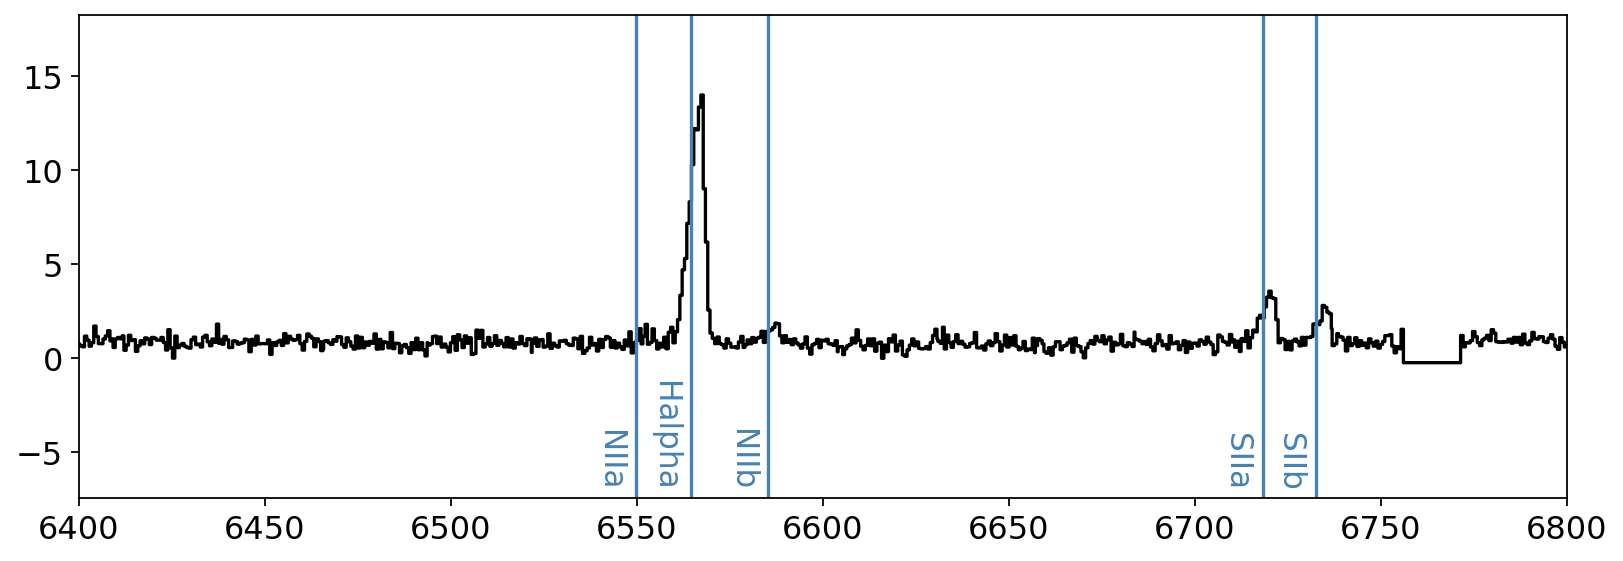

In [18]:
plt.figure(figsize=(12,4))
plt.step(speccorr.wavelength, speccorr.flux, color='black') 
xmin, xmax = 6400,6800
for line in line_dict:
    wline = line_dict[line]
    if xmin<wline<xmax:
        plt.axvline(wline, color='steelblue')
        plt.text(wline-3, -7, line, {'color': 'steelblue', 'fontsize': 14},
             horizontalalignment='right',
             verticalalignment='bottom',
             rotation=270)
plt.xlim(xmin, xmax)

(4800, 5100)

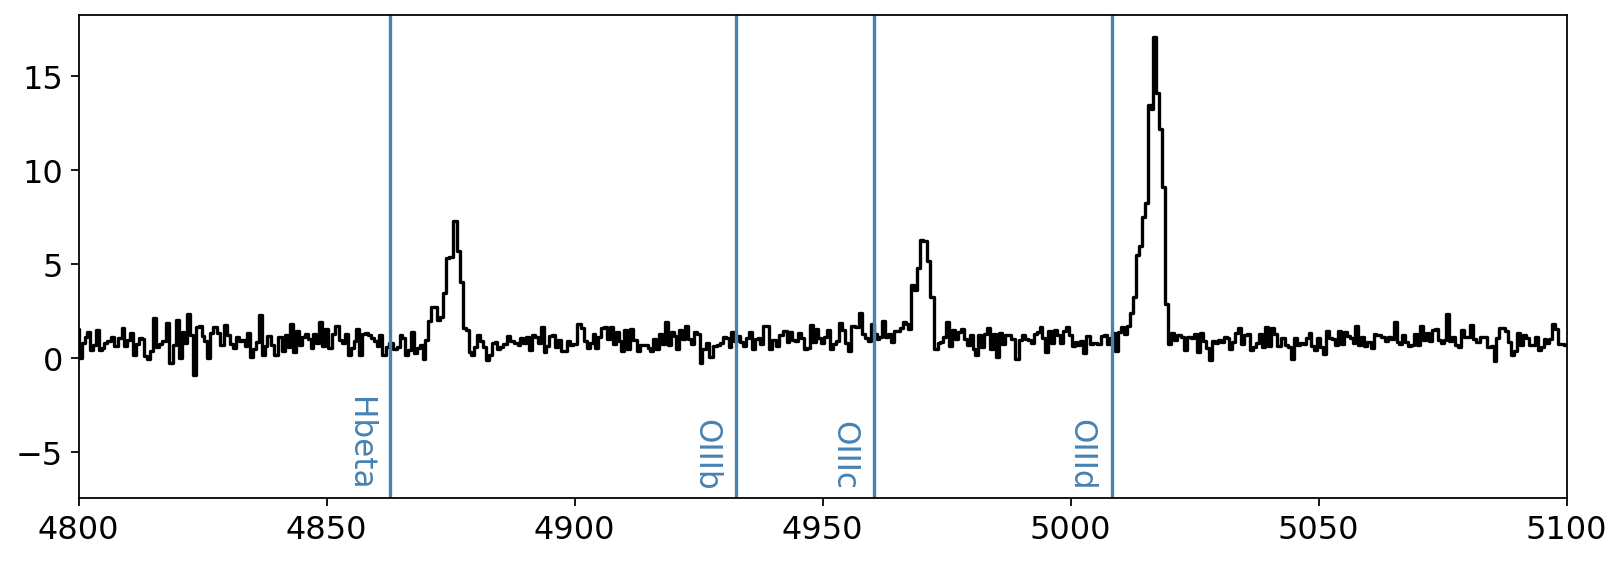

In [19]:
plt.figure(figsize=(12,4))
plt.step(speccorr.wavelength, speccorr.flux, color='black') 
xmin, xmax = 4800,5100
for line in line_dict:
    wline = line_dict[line]
    if xmin<wline<xmax:
        plt.axvline(wline, color='steelblue')
        plt.text(wline-3, -7, line, {'color': 'steelblue', 'fontsize': 14},
             horizontalalignment='right',
             verticalalignment='bottom',
             rotation=270)
plt.xlim(xmin, xmax)

(6530, 6630)

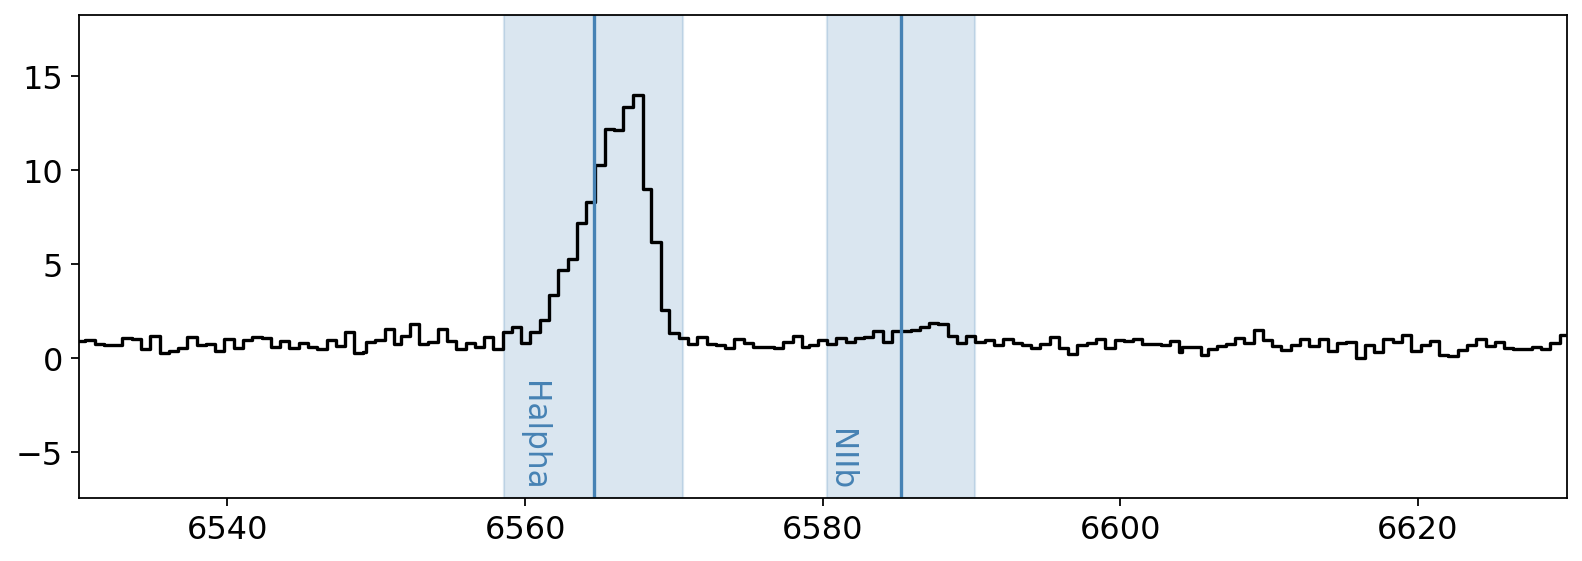

In [20]:
plt.figure(figsize=(12,4))
plt.step(speccorr.wavelength, speccorr.flux, color='black') 
xmin, xmax = 6530,6630
widths = [12, 10]
for i, line in enumerate(['Halpha', 'NIIb']):
    wline = line_dict[line]
    if xmin<wline<xmax:
        plt.axvline(wline, color='steelblue')
        width = widths[i]
        plt.axvspan(wline-width/2, wline+width/2, alpha=0.2, color='steelblue')
        plt.text(wline-3, -7, line, {'color': 'steelblue', 'fontsize': 14},
             horizontalalignment='right',
             verticalalignment='bottom',
             rotation=270)
plt.xlim(xmin, xmax)

In [22]:
from specutils.analysis import line_flux
from specutils.analysis import equivalent_width

speccorr_cont = speccorr #+ 5*u.Unit('erg cm-2 s-1 AA-1')

In [23]:
line = 'Halpha'
region_width = 12.0
wmin = (line_dict[line]-region_width/2)*u.AA
wmax = (line_dict[line]+region_width/2)*u.AA
flux_halpha = line_flux(speccorr, SpectralRegion(wmin, wmax))
ew_halpha = equivalent_width(speccorr_cont, regions=SpectralRegion(wmin, wmax))

line = 'NIIb'
region_width = 10.0
wmin = (line_dict[line]-region_width/2)*u.AA
wmax = (line_dict[line]+region_width/2)*u.AA
flux_nII = line_flux(speccorr, SpectralRegion(wmin, wmax))
ew_nII = equivalent_width(speccorr_cont, regions=SpectralRegion(wmin, wmax))

In [24]:
print(flux_halpha, flux_nII)
print(ew_halpha, ew_nII)

72.46531283009706 Angstrom 12.45355376608536 Angstrom
-61.250618587559146 Angstrom -2.483086918077287 Angstrom


(4850, 5050)

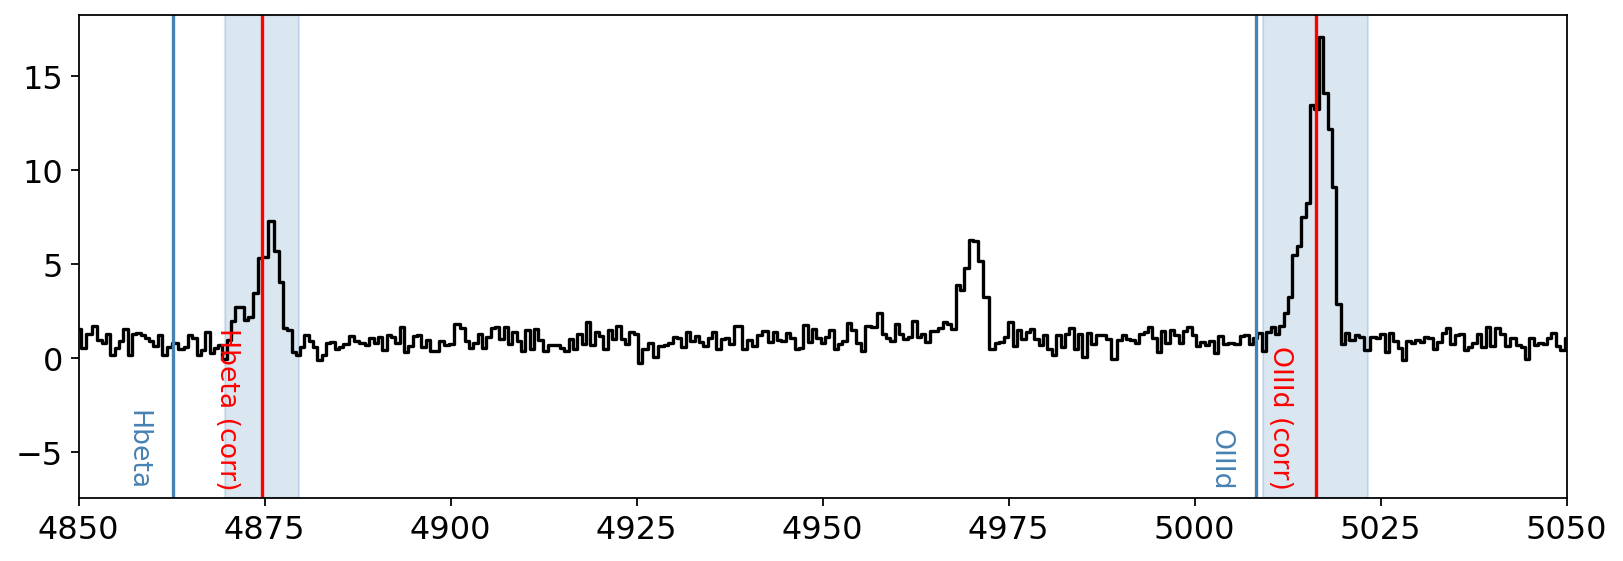

In [25]:
plt.figure(figsize=(12,4))
plt.step(speccorr.wavelength, speccorr.flux, color='black') 
xmin, xmax = 4850,5050
widths = [10, 14]
fixes = [12, 8]
for i, line in enumerate(['Hbeta', 'OIIId']):
    wline = line_dict[line] + fixes[i] # HAD TO FIX
    if xmin<wline<xmax:
        plt.axvline(wline, color='red')
        plt.axvline(line_dict[line], color='steelblue')
        width = widths[i]
        plt.axvspan(wline-width/2, wline+width/2, alpha=0.2, color='steelblue')
        plt.text(wline-3, -7, line+' (corr)', {'color': 'red', 'fontsize': 12},
             horizontalalignment='right',
             verticalalignment='bottom',
             rotation=270)
        plt.text(line_dict[line]-3, -7, line, {'color': 'steelblue', 'fontsize': 12},
             horizontalalignment='right',
             verticalalignment='bottom',
             rotation=270)
plt.xlim(xmin, xmax)

In [26]:
line = 'Hbeta'
region_width = 10.0
wfix = line_dict[line]+12
wmin = (wfix-region_width/2)*u.AA
wmax = (wfix+region_width/2)*u.AA
flux_hbeta = line_flux(speccorr, SpectralRegion(wmin, wmax))
ew_hbeta = equivalent_width(speccorr_cont, regions=SpectralRegion(wmin, wmax))

line = 'OIIId'
region_width = 14.0
wfix = line_dict[line]+8
wmin = (wfix-region_width/2)*u.AA
wmax = (wfix+region_width/2)*u.AA
flux_oIII = line_flux(speccorr, SpectralRegion(wmin, wmax))
ew_oIII = equivalent_width(speccorr_cont, regions=SpectralRegion(wmin, wmax))

In [27]:
print(flux_hbeta, flux_oIII)
print(ew_hbeta, ew_oIII)

30.688998139971822 Angstrom 74.75194769068061 Angstrom
-21.40398006376386 Angstrom -61.589287683829426 Angstrom


Text(-1.5, 0, 'star-forming')

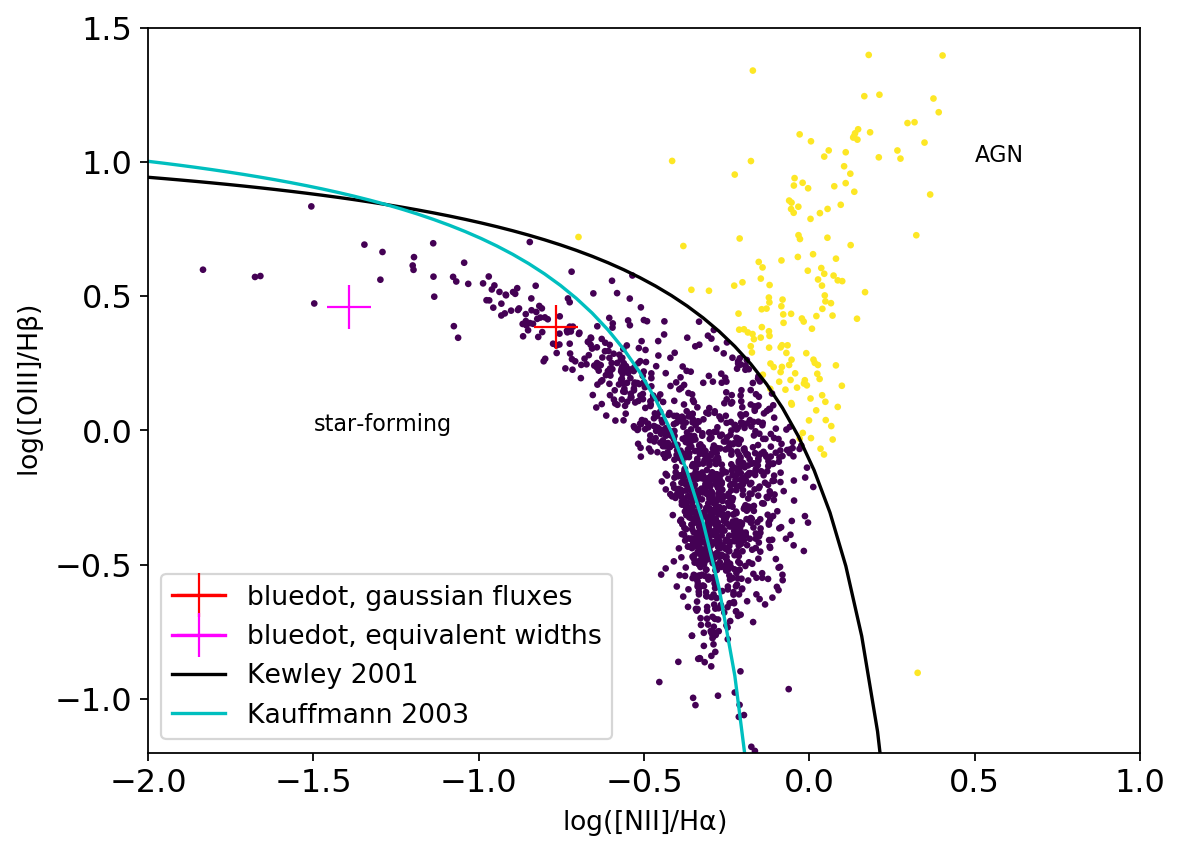

In [28]:
import numpy as np
from matplotlib import pyplot as plt

from astroML.datasets import fetch_sdss_corrected_spectra
from astroML.datasets.tools.sdss_fits import log_OIII_Hb_NII

plt.figure(figsize=(8,6))
plt.plot(np.log10(flux_nII/flux_halpha),np.log10(flux_oIII/flux_hbeta), marker='+', 
         color='red', markersize=20, label='bluedot, gaussian fluxes')
plt.plot(np.log10(ew_nII/ew_halpha),np.log10(ew_oIII/ew_hbeta), marker='+', 
         color='magenta', markersize=20, label='bluedot, equivalent widths')

data = fetch_sdss_corrected_spectra()

i = np.where((data['lineindex_cln'] == 4) | (data['lineindex_cln'] == 5))

plt.scatter(data['log_NII_Ha'][i], data['log_OIII_Hb'][i],
            c=data['lineindex_cln'][i], s=9, lw=0)

NII = np.linspace(-2.0, 0.35)
plt.plot(NII, log_OIII_Hb_NII(NII), '-k', label='Kewley 2001')
#plt.plot(NII, log_OIII_Hb_NII(NII, 0.1), '--k')
#plt.plot(NII, log_OIII_Hb_NII(NII, -0.1), '--k')

ka03 = 0.61/(NII-0.05) + 1.3
idx = [i for i in range(len(NII)) if NII[i]<0 ]
plt.plot(NII[idx], ka03[idx], '-c', label='Kauffmann 2003')

plt.xlim(-2.0, 1.0)
plt.ylim(-1.2, 1.5)
plt.legend(loc='lower left', **{'fontsize': 12})

plt.xlabel(r'$\mathrm{log([NII]/H\alpha)}$', fontsize='large')
plt.ylabel(r'$\mathrm{log([OIII]/H\beta)}$', fontsize='large')
plt.text(0.5, 1, "AGN")
plt.text(-1.5, 0, "star-forming")

In [29]:
import pandas as pd
info_fn = '../data/hsc_catalogs/pdr2_wide_icmod_20.0-20.5_clean_more.csv'
info_df = pd.read_csv(info_fn)
print("Read in info file {} with {} rows".format(info_fn, len(info_df)))
info_df = info_df.set_index('Unnamed: 0')

Read in info file ../data/hsc_catalogs/pdr2_wide_icmod_20.0-20.5_clean_more.csv with 942781 rows


In [30]:
infoid = 461525

In [31]:
info = info_df.loc[infoid]

In [32]:
gmag = info['g_cmodel_mag']
rmag = info['r_cmodel_mag']
imag = info['i_cmodel_mag']

-0.45046430000000015 0.10740280000000269


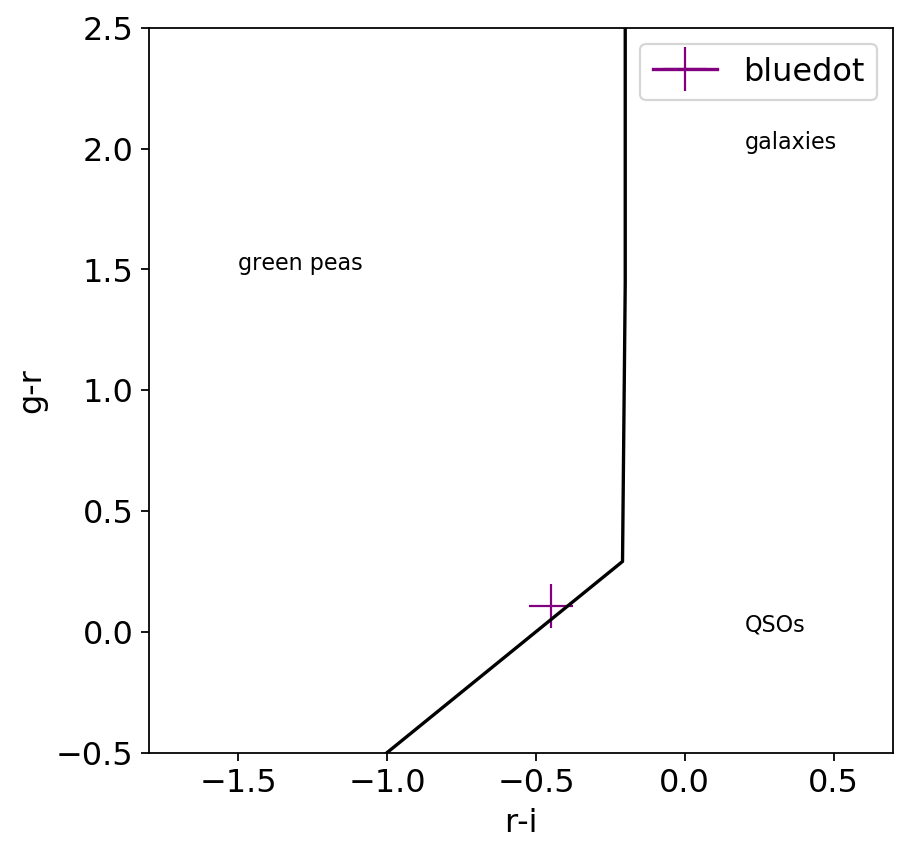

In [33]:
print(rmag-imag, gmag-rmag)
plt.figure(figsize=(6,6))
plt.plot(rmag-imag, gmag-rmag, marker='+', color='purple', markersize=20, label='bluedot')
rimin, rimax = -1.8, 0.7
grmin, grmax = -0.5, 2.5 
plt.xlim(rimin, rimax)
plt.ylim(grmin, grmax)

gr = np.linspace(grmin, grmax, 100)
ri = np.linspace(rimin, rimax, 100)

ricut = []
grcut = []
for i in range(len(ri)):
    #if gr[i]<=0.3:
    grval = ri[i]+0.5
    if grval<=0.3:
        ricut.append(ri[i])
        grcut.append(grval)
    else:
        ricut.append(-0.2)
        grcut.append(gr[i])
plt.plot(ricut, grcut, color='k')

plt.text(-1.5, 1.5, 'green peas')
plt.text(0.2, 2, 'galaxies')
plt.text(0.2, 0, 'QSOs')

plt.xlabel("r-i")
plt.ylabel("g-r")
plt.legend()